#### How to use Boosting

https://keeryang.github.io/papers/Profits_2021Aug28.pdf

In [577]:
import optuna
from lightgbm import plot_importance, LGBMRegressor
import getFamaFrenchFactors as gff
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [578]:
stocks_df = pd.read_csv('../data/market_data/sp500/sp500_stocks.csv')
df = stocks_df.pivot(
    index='Date', columns='Symbol', values='Adj Close')

df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

df.head()

Symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.122227,4.496877,6.470741,NaN,NaN,18.952162,7.994444,32.212460,37.090000,23.694084,...,52.883579,9.905468,41.963718,12.918809,43.185623,NaN,19.158102,52.587051,28.670000,NaN
2010-01-05,19.903643,5.005957,6.481929,NaN,NaN,18.799042,7.967778,32.411549,37.700001,23.656675,...,52.765053,10.115747,44.515926,12.765595,43.354244,NaN,19.092571,54.251759,28.620001,NaN
2010-01-06,19.832930,4.798554,6.378825,NaN,NaN,18.903446,7.933333,32.756096,37.619999,23.611784,...,53.614498,10.003899,43.932011,12.790110,43.728970,NaN,18.956089,54.234219,28.400000,NaN
2010-01-07,19.807215,4.939964,6.367033,NaN,NaN,19.060045,7.886667,32.725471,36.889999,23.424749,...,53.456463,9.959157,44.870213,12.734954,43.591564,NaN,18.950626,55.478374,27.690001,NaN
2010-01-08,19.800785,4.845691,6.409364,NaN,NaN,19.157482,7.871111,32.595306,36.689999,23.559416,...,53.397202,9.867439,44.548744,12.741086,43.416687,NaN,18.956089,54.313072,27.600000,NaN


In [579]:
df.shape

(3611, 503)

In [580]:
tickers = ['AAPL']

In [581]:
ff5 = pd.DataFrame(gff.famaFrench5Factor(frequency='m'))
ff5

,date_ff_factors,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-31,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027
1,1963-08-31,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
2,1963-09-30,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
3,1963-10-31,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
4,1963-11-30,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027
...,...,...,...,...,...,...,...
724,2023-11-30,0.0884,-0.0012,0.0164,-0.0391,-0.0100,0.0044
725,2023-12-31,0.0487,0.0732,0.0493,-0.0307,0.0132,0.0043
726,2024-01-31,0.0071,-0.0574,-0.0238,0.0069,-0.0096,0.0047
727,2024-02-29,0.0506,-0.0078,-0.0349,-0.0199,-0.0214,0.0042


In [582]:
fff = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

N_lags = 10

for f in fff:
  for i in range(1, N_lags):
    ff5[f'{f}_{i}L'] = ff5[f].shift(-i)
    

In [583]:
mon = pd.DataFrame(df[tickers[0]]).resample('ME').last()
mon_rets = mon.pct_change().dropna()

In [584]:
import numpy as np

# Пример преобразования с использованием логарифма
log_transformed_features = np.log1p(
    ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']])

log_transformed_features

,Mkt-RF,SMB,HML,RMW,CMA,RF
0,-0.003908,-0.004108,-0.009747,0.006777,-0.011870,0.002696
1,0.049457,-0.008032,0.017840,0.003594,-0.003506,0.002497
2,-0.015825,-0.005214,0.001299,-0.007125,0.002896,0.002696
3,0.024985,-0.013998,-0.001001,0.027615,-0.020305,0.002896
4,-0.008536,-0.008839,0.017349,-0.005113,0.022153,0.002696
...,...,...,...,...,...,...
724,0.084709,-0.001201,0.016267,-0.039885,-0.010050,0.004390
725,0.047551,0.070645,0.048123,-0.031181,0.013114,0.004291
726,0.007075,-0.059113,-0.024088,0.006876,-0.009646,0.004689
727,0.049361,-0.007831,-0.035524,-0.020101,-0.021632,0.004191


In [585]:
sqrt_transformed_features = np.sqrt(
    np.abs(ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]))
sqrt_transformed_features

,Mkt-RF,SMB,HML,RMW,CMA,RF
0,0.062450,0.064031,0.098489,0.082462,0.108628,0.051962
1,0.225167,0.089443,0.134164,0.060000,0.059161,0.050000
2,0.125300,0.072111,0.036056,0.084261,0.053852,0.051962
3,0.159060,0.117898,0.031623,0.167332,0.141774,0.053852
4,0.092195,0.093808,0.132288,0.071414,0.149666,0.051962
...,...,...,...,...,...,...
724,0.297321,0.034641,0.128062,0.197737,0.100000,0.066332
725,0.220681,0.270555,0.222036,0.175214,0.114891,0.065574
726,0.084261,0.239583,0.154272,0.083066,0.097980,0.068557
727,0.224944,0.088318,0.186815,0.141067,0.146287,0.064807


In [586]:
mixed_transformed_feature = np.sqrt(np.abs(np.log1p(ff5['Mkt-RF'] + ff5['SMB'])))
mixed_transformed_feature

0      0.089622
1      0.204484
2      0.145332
3      0.106468
4      0.132104
         ...   
724    0.289146
725    0.339151
726    0.227176
727    0.204718
728    0.128694
Length: 729, dtype: float64

In [587]:
squared_features = ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]**2
cubed_features = ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]**3

In [588]:
Mkt_RF_SMA = ff5['Mkt-RF'].rolling(window=3).mean()
Mkt_RF_SMA

0           NaN
1           NaN
2      0.010367
3      0.020100
4      0.000367
         ...   
724    0.001367
725    0.035067
726    0.048067
727    0.035467
728    0.028667
Name: Mkt-RF, Length: 729, dtype: float64

## Обучение бустинга

In [589]:
ff5

,date_ff_factors,Mkt-RF,SMB,HML,RMW,CMA,RF,Mkt-RF_1L,Mkt-RF_2L,Mkt-RF_3L,...,RMW_9L,CMA_1L,CMA_2L,CMA_3L,CMA_4L,CMA_5L,CMA_6L,CMA_7L,CMA_8L,CMA_9L
0,1963-07-31,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027,0.0507,-0.0157,0.0253,...,-0.0127,-0.0035,0.0029,-0.0201,0.0224,-0.0007,0.0147,0.0091,0.0322,-0.0108
1,1963-08-31,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025,-0.0157,0.0253,-0.0085,...,-0.0016,0.0029,-0.0201,0.0224,-0.0007,0.0147,0.0091,0.0322,-0.0108,0.0017
2,1963-09-30,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027,0.0253,-0.0085,0.0183,...,-0.0028,-0.0201,0.0224,-0.0007,0.0147,0.0091,0.0322,-0.0108,0.0017,-0.0017
3,1963-10-31,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029,-0.0085,0.0183,0.0224,...,0.0008,0.0224,-0.0007,0.0147,0.0091,0.0322,-0.0108,0.0017,-0.0017,0.0191
4,1963-11-30,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027,0.0183,0.0224,0.0154,...,0.0012,-0.0007,0.0147,0.0091,0.0322,-0.0108,0.0017,-0.0017,0.0191,0.0035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,2023-11-30,0.0884,-0.0012,0.0164,-0.0391,-0.0100,0.0044,0.0487,0.0071,0.0506,...,NaN,0.0132,-0.0096,-0.0214,0.0118,NaN,NaN,NaN,NaN,NaN
725,2023-12-31,0.0487,0.0732,0.0493,-0.0307,0.0132,0.0043,0.0071,0.0506,0.0283,...,NaN,-0.0096,-0.0214,0.0118,NaN,NaN,NaN,NaN,NaN,NaN
726,2024-01-31,0.0071,-0.0574,-0.0238,0.0069,-0.0096,0.0047,0.0506,0.0283,NaN,...,NaN,-0.0214,0.0118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
727,2024-02-29,0.0506,-0.0078,-0.0349,-0.0199,-0.0214,0.0042,0.0283,NaN,NaN,...,NaN,0.0118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [590]:
factors = ff5.rename(columns={'date_ff_factors': 'Date'})
factors_0 = pd.merge(mon_rets, factors, on='Date', how='left')
factors_0 = factors_0.dropna()

Y = (factors_0[tickers[0]] - factors_0['RF'])
X = factors_0.drop(
    columns=['RF', tickers[0]]).set_index('Date')

# 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'

In [591]:
X

,Mkt-RF,SMB,HML,RMW,CMA,Mkt-RF_1L,Mkt-RF_2L,Mkt-RF_3L,Mkt-RF_4L,Mkt-RF_5L,...,RMW_9L,CMA_1L,CMA_2L,CMA_3L,CMA_4L,CMA_5L,CMA_6L,CMA_7L,CMA_8L,CMA_9L
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143,0.0631,0.0200,-0.0789,-0.0557,0.0693,...,0.0045,0.0169,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169,0.0200,-0.0789,-0.0557,0.0693,-0.0477,...,-0.0344,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172,-0.0789,-0.0557,0.0693,-0.0477,0.0954,...,-0.0076,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021,-0.0557,0.0693,-0.0477,0.0954,0.0388,...,-0.0194,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088
2010-06-30,-0.0557,-0.0247,-0.0470,-0.0016,-0.0155,0.0693,-0.0477,0.0954,0.0388,0.0060,...,0.0176,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088,-0.0003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,-0.0258,0.0066,-0.0081,0.0101,-0.0133,0.0251,0.0061,0.0035,0.0646,0.0321,...,-0.0391,-0.0237,0.0286,-0.0722,-0.0162,0.0057,-0.0237,-0.0083,-0.0065,-0.0100
2023-03-31,0.0251,-0.0694,-0.0885,0.0224,-0.0237,0.0061,0.0035,0.0646,0.0321,-0.0239,...,-0.0307,0.0286,-0.0722,-0.0162,0.0057,-0.0237,-0.0083,-0.0065,-0.0100,0.0132
2023-04-30,0.0061,-0.0256,-0.0004,0.0242,0.0286,0.0035,0.0646,0.0321,-0.0239,-0.0524,...,0.0069,-0.0722,-0.0162,0.0057,-0.0237,-0.0083,-0.0065,-0.0100,0.0132,-0.0096


In [592]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=False)

In [593]:
X_train.head()

,Mkt-RF,SMB,HML,RMW,CMA,Mkt-RF_1L,Mkt-RF_2L,Mkt-RF_3L,Mkt-RF_4L,Mkt-RF_5L,...,RMW_9L,CMA_1L,CMA_2L,CMA_3L,CMA_4L,CMA_5L,CMA_6L,CMA_7L,CMA_8L,CMA_9L
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143,0.0631,0.0200,-0.0789,-0.0557,0.0693,...,0.0045,0.0169,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169,0.0200,-0.0789,-0.0557,0.0693,-0.0477,...,-0.0344,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172,-0.0789,-0.0557,0.0693,-0.0477,0.0954,...,-0.0076,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021,-0.0557,0.0693,-0.0477,0.0954,0.0388,...,-0.0194,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088
2010-06-30,-0.0557,-0.0247,-0.0470,-0.0016,-0.0155,0.0693,-0.0477,0.0954,0.0388,0.0060,...,0.0176,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088,-0.0003


In [607]:
X.shape

(161, 50)

In [594]:
# selected_features = ['Mkt-RF', 'RMW', 'CMA']
# selected_features = ['CMA_8L', 'SMB_7L', 'CMA_6L']

selected_features = list(X.columns)
# selected_features.remove('date_ff_factors')
# selected_features.remove('RF')
                     
                  # 'HML_8L', 'HML_4L', 'RMW_9L', 'RMW_5L', 'SMB_1L']
                  
                  
# selected_features = ['SMB_5L',
#                      'HML_7L',
#                      'RMW_5L',
#                      'HML_2L',
#                      'CMA_9L',
#                      'HML_1L',
#                      'CMA_6L',
#                      'HML_4L',
#                      'CMA_8L',
#                      'RMW_6L',
#                      'SMB_6L',
#                     #  'RMW',
#                      'SMB_2L',
#                     #  'CMA',
#                     #  'Mkt-RF'
#                      ]


In [595]:
selected_features

['Mkt-RF',
 'SMB',
 'HML',
 'RMW',
 'CMA',
 'Mkt-RF_1L',
 'Mkt-RF_2L',
 'Mkt-RF_3L',
 'Mkt-RF_4L',
 'Mkt-RF_5L',
 'Mkt-RF_6L',
 'Mkt-RF_7L',
 'Mkt-RF_8L',
 'Mkt-RF_9L',
 'SMB_1L',
 'SMB_2L',
 'SMB_3L',
 'SMB_4L',
 'SMB_5L',
 'SMB_6L',
 'SMB_7L',
 'SMB_8L',
 'SMB_9L',
 'HML_1L',
 'HML_2L',
 'HML_3L',
 'HML_4L',
 'HML_5L',
 'HML_6L',
 'HML_7L',
 'HML_8L',
 'HML_9L',
 'RMW_1L',
 'RMW_2L',
 'RMW_3L',
 'RMW_4L',
 'RMW_5L',
 'RMW_6L',
 'RMW_7L',
 'RMW_8L',
 'RMW_9L',
 'CMA_1L',
 'CMA_2L',
 'CMA_3L',
 'CMA_4L',
 'CMA_5L',
 'CMA_6L',
 'CMA_7L',
 'CMA_8L',
 'CMA_9L']

In [596]:
X[selected_features].head()

,Mkt-RF,SMB,HML,RMW,CMA,Mkt-RF_1L,Mkt-RF_2L,Mkt-RF_3L,Mkt-RF_4L,Mkt-RF_5L,...,RMW_9L,CMA_1L,CMA_2L,CMA_3L,CMA_4L,CMA_5L,CMA_6L,CMA_7L,CMA_8L,CMA_9L
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143,0.0631,0.0200,-0.0789,-0.0557,0.0693,...,0.0045,0.0169,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169,0.0200,-0.0789,-0.0557,0.0693,-0.0477,...,-0.0344,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172,-0.0789,-0.0557,0.0693,-0.0477,0.0954,...,-0.0076,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021,-0.0557,0.0693,-0.0477,0.0954,0.0388,...,-0.0194,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088
2010-06-30,-0.0557,-0.0247,-0.0470,-0.0016,-0.0155,0.0693,-0.0477,0.0954,0.0388,0.0060,...,0.0176,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088,-0.0003


In [597]:
def objective(trial):

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 100),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 100),
        # 'importance_type': 'split',
        'importance_type': trial.suggest_categorical('importance_type', ['split', 'gain']),

        'n_jobs': 12,
        'random_state': 42
    }

    regr = LGBMRegressor(**params)
    regr.fit(X_train.loc[:, selected_features], y_train)
    preds = regr.predict(X_test.loc[:, selected_features])
    # mse = mean_squared_error(y_test, preds)
    # return mse
    return r2_score(y_test, preds)

In [598]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-05-10 18:03:43,205] A new study created in memory with name: no-name-a4312ea2-4979-41ba-960f-e6812632481f
[I 2024-05-10 18:03:43,214] Trial 0 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.0638545996559678, 'num_leaves': 10, 'n_estimators': 19, 'max_depth': 52, 'min_data_in_leaf': 34, 'feature_fraction': 0.6315922456472162, 'subsample': 0.78642161370345, 'lambda_l1': 92.98838244555662, 'lambda_l2': 74.104466295889, 'importance_type': 'split'}. Best is trial 0 with value: -0.00941605220776709.
[I 2024-05-10 18:03:43,223] Trial 1 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.03781889171039048, 'num_leaves': 54, 'n_estimators': 94, 'max_depth': 42, 'min_data_in_leaf': 70, 'feature_fraction': 0.78986336330761, 'subsample': 0.7326705715925257, 'lambda_l1': 58.687681097762365, 'lambda_l2': 47.1315382680128, 'importance_type': 'split'}. Best is trial 0 with value: -0.00941605220776709.
[I 2024-05-10 18:03:43,236] Trial 2 f

[LightGBM] [Warning] lambda_l1 is set=92.98838244555662, reg_alpha=0.0 will be ignored. Current value: lambda_l1=92.98838244555662
[LightGBM] [Warning] feature_fraction is set=0.6315922456472162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6315922456472162
[LightGBM] [Warning] lambda_l2 is set=74.104466295889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.104466295889
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] lambda_l1 is set=92.98838244555662, reg_alpha=0.0 will be ignored. Current value: lambda_l1=92.98838244555662
[LightGBM] [Warning] feature_fraction is set=0.6315922456472162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6315922456472162
[LightGBM] [Warning] lambda_l2 is set=74.104466295889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.104466295889
[LightGBM] [Warning] min_data_in_leaf is set=34, min

[I 2024-05-10 18:03:43,424] Trial 10 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.011338406277204869, 'num_leaves': 39, 'n_estimators': 168, 'max_depth': 69, 'min_data_in_leaf': 36, 'feature_fraction': 0.4112368563458463, 'subsample': 0.9626188260373268, 'lambda_l1': 62.439565066113246, 'lambda_l2': 8.872105857395098, 'importance_type': 'split'}. Best is trial 0 with value: -0.00941605220776709.
[I 2024-05-10 18:03:43,443] Trial 11 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.08683962653847463, 'num_leaves': 53, 'n_estimators': 10, 'max_depth': 57, 'min_data_in_leaf': 95, 'feature_fraction': 0.7757711828076497, 'subsample': 0.9481240043601857, 'lambda_l1': 67.38414766858038, 'lambda_l2': 96.84866304543752, 'importance_type': 'split'}. Best is trial 0 with value: -0.00941605220776709.
[I 2024-05-10 18:03:43,476] Trial 12 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.01586206620426442, 'num_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-05-10 18:03:43,747] Trial 18 finished with value: 0.3220063425413423 and parameters: {'learning_rate': 0.04842706282746361, 'num_leaves': 12, 'n_estimators': 135, 'max_depth': 34, 'min_data_in_leaf': 10, 'feature_fraction': 0.8661789711708902, 'subsample': 0.170371705884434, 'lambda_l1': 0.7524109788791833, 'lambda_l2': 80.78937438126133, 'importance_type': 'split'}. Best is trial 18 with value: 0.3220063425413423.
[I 2024-05-10 18:03:43,784] Trial 19 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.08682346643060888, 'num_leaves': 10, 'n_estimators': 132, 'max_depth': 33, 'min_data_in_leaf': 10, 'feature_fraction': 0.9763902132789655, 'subsample': 0.1502807181050432, 'lambda_l1': 2.985874195492478, 'lambda_l2': 79.52044038446246, 'importance_type': 'split'}. Best is trial 18 with value: 0.3220063425413423.
[I 2024-05-10 18:03:43,825] Trial 20 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.1914279004999152, 'num_leaves

[LightGBM] [Warning] lambda_l1 is set=0.7524109788791833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7524109788791833
[LightGBM] [Warning] feature_fraction is set=0.8661789711708902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661789711708902
[LightGBM] [Warning] lambda_l2 is set=80.78937438126133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.78937438126133
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=0.7524109788791833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7524109788791833
[LightGBM] [Warning] feature_fraction is set=0.8661789711708902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661789711708902
[LightGBM] [Warning] lambda_l2 is set=80.78937438126133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.78937438126133
[LightGBM] [Warning] min_data_in_leaf is

[I 2024-05-10 18:03:43,849] Trial 21 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.04514611681918327, 'num_leaves': 16, 'n_estimators': 122, 'max_depth': 36, 'min_data_in_leaf': 75, 'feature_fraction': 0.7237763765872419, 'subsample': 0.10150858486357164, 'lambda_l1': 86.40630008721675, 'lambda_l2': 59.07025013922165, 'importance_type': 'split'}. Best is trial 18 with value: 0.3220063425413423.
[I 2024-05-10 18:03:43,891] Trial 22 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.02488153692133434, 'num_leaves': 44, 'n_estimators': 167, 'max_depth': 16, 'min_data_in_leaf': 47, 'feature_fraction': 0.8276185858962793, 'subsample': 0.6252719172322935, 'lambda_l1': 58.03855014603664, 'lambda_l2': 78.57166101524177, 'importance_type': 'split'}. Best is trial 18 with value: 0.3220063425413423.
[I 2024-05-10 18:03:43,936] Trial 23 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.060427582158394215, 'num_l

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] lambda_l1 is set=86.40630008721675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=86.40630008721675
[LightGBM] [Warning] feature_fraction is set=0.7237763765872419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7237763765872419
[LightGBM] [Warning] lambda_l2 is set=59.07025013922165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.07025013922165
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 128, number of used features: 0
[LightGBM] [Info] Start training from score 0.026105
[LightGBM] [Warning] Stopped training because there are no more leave

[I 2024-05-10 18:03:44,062] Trial 27 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.06700767333355133, 'num_leaves': 70, 'n_estimators': 59, 'max_depth': 45, 'min_data_in_leaf': 69, 'feature_fraction': 0.8493220034785536, 'subsample': 0.9138687729977271, 'lambda_l1': 1.0467668292359886, 'lambda_l2': 90.89972672239614, 'importance_type': 'split'}. Best is trial 18 with value: 0.3220063425413423.
[I 2024-05-10 18:03:44,089] Trial 28 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.03961199039008644, 'num_leaves': 19, 'n_estimators': 181, 'max_depth': 75, 'min_data_in_leaf': 89, 'feature_fraction': 0.9172149175300004, 'subsample': 0.8037510811190532, 'lambda_l1': 12.032385325469889, 'lambda_l2': 60.0778966325463, 'importance_type': 'split'}. Best is trial 18 with value: 0.3220063425413423.
[I 2024-05-10 18:03:44,128] Trial 29 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.050684360838049114, 'num_le

[LightGBM] [Warning] lambda_l1 is set=1.0467668292359886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0467668292359886
[LightGBM] [Warning] feature_fraction is set=0.8493220034785536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8493220034785536
[LightGBM] [Warning] lambda_l2 is set=90.89972672239614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.89972672239614
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] lambda_l1 is set=1.0467668292359886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0467668292359886
[LightGBM] [Warning] feature_fraction is set=0.8493220034785536, colsample_bytree=1.0 will be ignored. Curre

[I 2024-05-10 18:03:44,271] Trial 35 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.0761925083133432, 'num_leaves': 23, 'n_estimators': 46, 'max_depth': 40, 'min_data_in_leaf': 76, 'feature_fraction': 0.39581291570372845, 'subsample': 0.6936387986352993, 'lambda_l1': 31.381066876953618, 'lambda_l2': 74.9934751438373, 'importance_type': 'gain'}. Best is trial 18 with value: 0.3220063425413423.
[I 2024-05-10 18:03:44,295] Trial 36 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.048119888482759485, 'num_leaves': 64, 'n_estimators': 25, 'max_depth': 49, 'min_data_in_leaf': 17, 'feature_fraction': 0.6456898215348054, 'subsample': 0.47583845403448266, 'lambda_l1': 9.109305339842962, 'lambda_l2': 41.726925430026505, 'importance_type': 'gain'}. Best is trial 18 with value: 0.3220063425413423.
[I 2024-05-10 18:03:44,328] Trial 37 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.03126303309825451, 'num_leav

[LightGBM] [Warning] lambda_l1 is set=31.381066876953618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=31.381066876953618
[LightGBM] [Warning] feature_fraction is set=0.39581291570372845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39581291570372845
[LightGBM] [Warning] lambda_l2 is set=74.9934751438373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.9934751438373
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] lambda_l1 is set=31.381066876953618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=31.381066876953618
[LightGBM] [Warning] feature_fraction is set=0.39581291570372845, colsample_bytree=1.0 will be ignored. Curr

[I 2024-05-10 18:03:44,484] Trial 42 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.388067569017642, 'num_leaves': 20, 'n_estimators': 42, 'max_depth': 3, 'min_data_in_leaf': 14, 'feature_fraction': 0.5006199405595659, 'subsample': 0.7401440931551543, 'lambda_l1': 16.31472565793013, 'lambda_l2': 66.79917951405596, 'importance_type': 'split'}. Best is trial 18 with value: 0.3220063425413423.
[I 2024-05-10 18:03:44,512] Trial 43 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.24274561701100134, 'num_leaves': 39, 'n_estimators': 57, 'max_depth': 50, 'min_data_in_leaf': 21, 'feature_fraction': 0.5832054182402036, 'subsample': 0.8029544375824299, 'lambda_l1': 30.70965122197081, 'lambda_l2': 62.412441252039244, 'importance_type': 'split'}. Best is trial 18 with value: 0.3220063425413423.
[I 2024-05-10 18:03:44,534] Trial 44 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.07809862533628646, 'num_leaves'

[LightGBM] [Warning] lambda_l1 is set=16.31472565793013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16.31472565793013
[LightGBM] [Warning] feature_fraction is set=0.5006199405595659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006199405595659
[LightGBM] [Warning] lambda_l2 is set=66.79917951405596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.79917951405596
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] lambda_l1 is set=16.31472565793013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16.31472565793013
[LightGBM] [Warning] feature_fraction is set=0.5006199405595659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5006199405595659
[LightGBM] [Warning] lambda_l2 is set=66.79917951405596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.79917951405596
[LightGBM] [Warning] min_data_in_leaf is set

[I 2024-05-10 18:03:44,688] Trial 49 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.1469123525686761, 'num_leaves': 27, 'n_estimators': 66, 'max_depth': 36, 'min_data_in_leaf': 40, 'feature_fraction': 0.749966149112331, 'subsample': 0.8560927404381304, 'lambda_l1': 3.619452871451416, 'lambda_l2': 92.57482338595172, 'importance_type': 'split'}. Best is trial 48 with value: 0.38370394968646593.
[I 2024-05-10 18:03:44,727] Trial 50 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.05634018129311254, 'num_leaves': 56, 'n_estimators': 131, 'max_depth': 37, 'min_data_in_leaf': 31, 'feature_fraction': 0.8750551763409996, 'subsample': 0.7277835886792885, 'lambda_l1': 53.65106493112934, 'lambda_l2': 97.82533988486534, 'importance_type': 'split'}. Best is trial 48 with value: 0.38370394968646593.
[I 2024-05-10 18:03:44,769] Trial 51 finished with value: 0.4220548096038804 and parameters: {'learning_rate': 0.19602252798821435, 'num_leaves

[LightGBM] [Warning] lambda_l1 is set=3.619452871451416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.619452871451416
[LightGBM] [Warning] feature_fraction is set=0.749966149112331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.749966149112331
[LightGBM] [Warning] lambda_l2 is set=92.57482338595172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92.57482338595172
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2151
[LightGBM] [Info] Number of data points in the train set: 128, number of used features: 50
[LightGBM] [Info] Start training from score 0.026105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because th

[I 2024-05-10 18:03:44,895] Trial 54 finished with value: 0.509385297099719 and parameters: {'learning_rate': 0.49815887782871, 'num_leaves': 13, 'n_estimators': 52, 'max_depth': 51, 'min_data_in_leaf': 26, 'feature_fraction': 0.8406570982153583, 'subsample': 0.9243868027545755, 'lambda_l1': 0.23826906391276506, 'lambda_l2': 88.66725206420926, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.
[I 2024-05-10 18:03:44,945] Trial 55 finished with value: 0.44595172705647856 and parameters: {'learning_rate': 0.2957204377337987, 'num_leaves': 17, 'n_estimators': 52, 'max_depth': 52, 'min_data_in_leaf': 25, 'feature_fraction': 0.9412619968141364, 'subsample': 0.9338229416598393, 'lambda_l1': 0.4467824197328989, 'lambda_l2': 99.72885454777888, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.
[I 2024-05-10 18:03:44,991] Trial 56 finished with value: 0.488871431191812 and parameters: {'learning_rate': 0.6391359717103983, 'num_leaves': 17, 'n_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 18:03:45,112] Trial 60 finished with value: 0.4235517117708565 and parameters: {'learning_rate': 0.3153549962589184, 'num_leaves': 30, 'n_estimators': 52, 'max_depth': 68, 'min_data_in_leaf': 39, 'feature_fraction': 0.9109715844296756, 'subsample': 0.8722681151835618, 'lambda_l1': 0.06948584955982978, 'lambda_l2': 84.54237864347347, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.
[I 2024-05-10 18:03:45,152] Trial 61 finished with value: 0.4410631566509664 and parameters: {'learning_rate': 0.2984922366559916, 'num_leaves': 28, 'n_estimators': 49, 'max_depth': 68, 'min_data_in_leaf': 34, 'feature_fraction': 0.8904919040432763, 'subsample': 0.8897973185245298, 'lambda_l1': 0.16093064749329286, 'lambda_l2': 88.12409502021623, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.
[I 2024-05-10 18:03:45,180] Trial 62 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.33278493850410934, 'num_leaves': 

[LightGBM] [Warning] lambda_l1 is set=0.06948584955982978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06948584955982978
[LightGBM] [Warning] feature_fraction is set=0.9109715844296756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9109715844296756
[LightGBM] [Warning] lambda_l2 is set=84.54237864347347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.54237864347347
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] lambda_l1 is set=0.06948584955982978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06948584955982978
[LightGBM] [Warning] feature_fraction is set=0.9109715844296756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9109715844296756
[LightGBM] [Warning] lambda_l2 is set=84.54237864347347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84.54237864347347
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-10 18:03:45,303] Trial 66 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.20934146929466263, 'num_leaves': 25, 'n_estimators': 44, 'max_depth': 73, 'min_data_in_leaf': 34, 'feature_fraction': 0.8866659660791837, 'subsample': 0.9775494367019483, 'lambda_l1': 14.147215217118015, 'lambda_l2': 89.63440677846924, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.
[I 2024-05-10 18:03:45,333] Trial 67 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.6431741882844761, 'num_leaves': 21, 'n_estimators': 65, 'max_depth': 64, 'min_data_in_leaf': 15, 'feature_fraction': 0.8000721617075168, 'subsample': 0.9402828886482868, 'lambda_l1': 3.973118461869332, 'lambda_l2': 94.27649498593902, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.
[I 2024-05-10 18:03:45,361] Trial 68 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.2728387354521147, 'num_leaves':

[LightGBM] [Warning] lambda_l1 is set=14.147215217118015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14.147215217118015
[LightGBM] [Warning] feature_fraction is set=0.8866659660791837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8866659660791837
[LightGBM] [Warning] lambda_l2 is set=89.63440677846924, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89.63440677846924
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] lambda_l1 is set=14.147215217118015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14.147215217118015
[LightGBM] [Warning] feature_fraction is set=0.8866659660791837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8866659660791837
[LightGBM] [Warning] lambda_l2 is set=89.63440677846924, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89.63440677846924
[LightGBM] [Warning] min_data_in_leaf is

[I 2024-05-10 18:03:45,500] Trial 72 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.6674101990017622, 'num_leaves': 12, 'n_estimators': 51, 'max_depth': 78, 'min_data_in_leaf': 25, 'feature_fraction': 0.9776000392100377, 'subsample': 0.8465967671216273, 'lambda_l1': 3.4214069783269174, 'lambda_l2': 88.93551017229039, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.
[I 2024-05-10 18:03:45,554] Trial 73 finished with value: 0.42288046809434443 and parameters: {'learning_rate': 0.9669859940617828, 'num_leaves': 18, 'n_estimators': 40, 'max_depth': 84, 'min_data_in_leaf': 32, 'feature_fraction': 0.9305140458316877, 'subsample': 0.7551679710397649, 'lambda_l1': 0.06510315052343646, 'lambda_l2': 97.46364883160582, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.
[I 2024-05-10 18:03:45,588] Trial 74 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.9433897893835425, 'num_leaves':

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-05-10 18:03:45,701] Trial 78 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.47633854059338326, 'num_leaves': 42, 'n_estimators': 37, 'max_depth': 54, 'min_data_in_leaf': 39, 'feature_fraction': 0.9347495437366252, 'subsample': 0.8820317550939601, 'lambda_l1': 3.8338366554108307, 'lambda_l2': 92.63809620466546, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.
[I 2024-05-10 18:03:45,731] Trial 79 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.7482946009946968, 'num_leaves': 22, 'n_estimators': 55, 'max_depth': 65, 'min_data_in_leaf': 31, 'feature_fraction': 0.8151900995027307, 'subsample': 0.9072371748046496, 'lambda_l1': 7.448226190183325, 'lambda_l2': 79.31025736594653, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.
[I 2024-05-10 18:03:45,759] Trial 80 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.34912882980433635, 'num_leaves'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-05-10 18:03:45,900] Trial 84 finished with value: 0.04869035614164874 and parameters: {'learning_rate': 0.9839210676946848, 'num_leaves': 47, 'n_estimators': 64, 'max_depth': 56, 'min_data_in_leaf': 24, 'feature_fraction': 0.8413236142646768, 'subsample': 0.7977366435263024, 'lambda_l1': 2.4558023073045314, 'lambda_l2': 99.52858532681172, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.
[I 2024-05-10 18:03:45,923] Trial 85 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.17400530758507352, 'num_leaves': 15, 'n_estimators': 17, 'max_depth': 70, 'min_data_in_leaf': 33, 'feature_fraction': 0.9442541786323346, 'subsample': 0.9982850017048053, 'lambda_l1': 11.75304627899544, 'lambda_l2': 88.42726159799976, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.
[I 2024-05-10 18:03:45,949] Trial 86 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.5769649096842718, 'num_leaves': 

[LightGBM] [Warning] lambda_l1 is set=2.4558023073045314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4558023073045314
[LightGBM] [Warning] feature_fraction is set=0.8413236142646768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8413236142646768
[LightGBM] [Warning] lambda_l2 is set=99.52858532681172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.52858532681172
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] lambda_l1 is set=11.75304627899544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11.75304627899544
[LightGBM] [Warning] feature_fraction is set=0.9442541786323346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9442541786323346
[LightGBM] [Warning] lambda_l2 is set=88.42726159799976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.42726159799976
[LightGBM] [Warning] min_data_in_leaf is s

[I 2024-05-10 18:03:46,100] Trial 91 finished with value: 0.028895489161837706 and parameters: {'learning_rate': 0.20991300370728314, 'num_leaves': 16, 'n_estimators': 40, 'max_depth': 47, 'min_data_in_leaf': 26, 'feature_fraction': 0.7883932013598419, 'subsample': 0.8177891408231693, 'lambda_l1': 2.528509480068149, 'lambda_l2': 87.32822357716975, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.
[I 2024-05-10 18:03:46,157] Trial 92 finished with value: 0.49297939892254883 and parameters: {'learning_rate': 0.38240694493816874, 'num_leaves': 18, 'n_estimators': 54, 'max_depth': 50, 'min_data_in_leaf': 23, 'feature_fraction': 0.8589116376298532, 'subsample': 0.8666098670970047, 'lambda_l1': 0.1095017478863291, 'lambda_l2': 16.749833043008152, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.
[I 2024-05-10 18:03:46,185] Trial 93 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.38472633323694655, 'num_leaves

[LightGBM] [Warning] lambda_l1 is set=0.1095017478863291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1095017478863291
[LightGBM] [Warning] feature_fraction is set=0.8589116376298532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8589116376298532
[LightGBM] [Warning] lambda_l2 is set=16.749833043008152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.749833043008152
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] lambda_l1 is set=0.1095017478863291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1095017478863291
[LightGBM] [Warning] feature_fraction is set=0.8589116376298532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8589116376298532
[LightGBM] [Warning] lambda_l2 is set=16.749833043008152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.749833043008152
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-10 18:03:46,363] Trial 98 finished with value: 0.44306561756787144 and parameters: {'learning_rate': 0.4105209278655255, 'num_leaves': 26, 'n_estimators': 54, 'max_depth': 63, 'min_data_in_leaf': 30, 'feature_fraction': 0.804827209980703, 'subsample': 0.9731875018297684, 'lambda_l1': 0.11927664525898023, 'lambda_l2': 90.32649083066958, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.
[I 2024-05-10 18:03:46,391] Trial 99 finished with value: -0.00941605220776709 and parameters: {'learning_rate': 0.495956503585303, 'num_leaves': 26, 'n_estimators': 49, 'max_depth': 55, 'min_data_in_leaf': 17, 'feature_fraction': 0.7645032530184255, 'subsample': 0.9719523429106002, 'lambda_l1': 5.507344060949078, 'lambda_l2': 89.90917303415517, 'importance_type': 'split'}. Best is trial 54 with value: 0.509385297099719.


[LightGBM] [Warning] lambda_l1 is set=0.11927664525898023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11927664525898023
[LightGBM] [Warning] feature_fraction is set=0.804827209980703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804827209980703
[LightGBM] [Warning] lambda_l2 is set=90.32649083066958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.32649083066958
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.11927664525898023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11927664525898023
[LightGBM] [Warning] feature_fraction is set=0.804827209980703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804827209980703
[LightGBM] [Warning] lambda_l2 is set=90.32649083066958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.32649083066958
[LightGBM] [Warning] min_data_in_leaf is

In [599]:
best_params = study.best_params
best_params

{'learning_rate': 0.49815887782871,
 'num_leaves': 13,
 'n_estimators': 52,
 'max_depth': 51,
 'min_data_in_leaf': 26,
 'feature_fraction': 0.8406570982153583,
 'subsample': 0.9243868027545755,
 'lambda_l1': 0.23826906391276506,
 'lambda_l2': 88.66725206420926,
 'importance_type': 'split'}

In [600]:
model_gbm = LGBMRegressor(**best_params)
model_gbm.fit(X=X_train.loc[:, selected_features], y=y_train)
preds = model_gbm.predict(X_test.loc[:, selected_features])

cross_val_score(model_gbm, X.loc[:, selected_features], Y, cv=5, scoring='r2')

[LightGBM] [Warning] lambda_l1 is set=0.23826906391276506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23826906391276506
[LightGBM] [Warning] feature_fraction is set=0.8406570982153583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8406570982153583
[LightGBM] [Warning] lambda_l2 is set=88.66725206420926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.66725206420926
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l1 is set=0.23826906391276506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23826906391276506
[LightGBM] [Warning] feature_fraction is set=0.8406570982153583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8406570982153583
[LightGBM] [Warning] lambda_l2 is set=88.66725206420926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.66725206420926
[LightGBM] [Warning] min_data_in_lea

array([ 0.06337017, -0.02225992,  0.08123151,  0.31972322,  0.48937583])

In [601]:
r2_score(y_test, preds)

0.48715917197679715

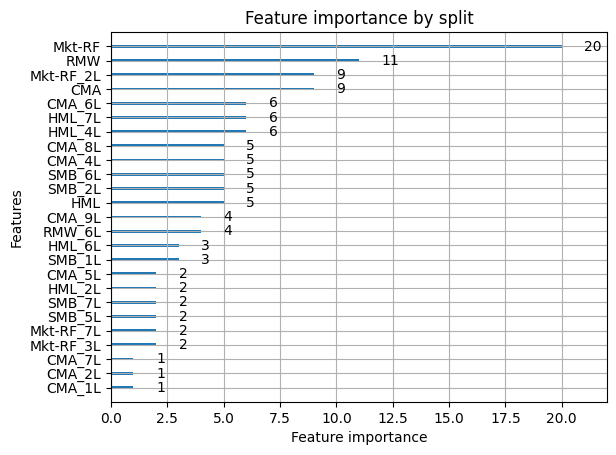

In [602]:
# fig = plt.plot(figsize=(15, 20))

top25 = 25

plot_importance(
    model_gbm,
    importance_type='split',
    max_num_features=min(top25, len(X.columns)),
    title="Feature importance by split",
)

# plot_importance(
#     model_gbm,
#     importance_type='gain',
#     max_num_features=min(top25, len(X.columns)),
#     title="Feature importance by gain",
# )

plt.show()

In [603]:
top15features_indexes = model_gbm.feature_importances_.argsort()[-15:]
top15features_stable = list(pd.Series(selected_features)[
                            top15features_indexes].values)

In [604]:
top15features_stable

['HML_6L',
 'RMW_6L',
 'CMA_9L',
 'CMA_8L',
 'SMB_6L',
 'SMB_2L',
 'CMA_4L',
 'HML',
 'HML_4L',
 'CMA_6L',
 'HML_7L',
 'Mkt-RF_2L',
 'CMA',
 'RMW',
 'Mkt-RF']